<a href="https://colab.research.google.com/github/ibelieveai/pytorchlearning/blob/master/ConvNets_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test for CUDA

In [2]:
import torch
import numpy as np

# check if cuda is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print("CUDA is not available. Training on CPU")
else:
  print("CUDA available. Training on GPU")

CUDA available. Training on GPU


## Loading the Dataset
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [5]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

#number of subprocess to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validaion
valid_size = 0.2

# convert data to a normalized torch tensor

transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

#choose the training and test datasets

train_data = datasets.CIFAR10('data', train=True, download= True, transform=transforms)
test_data = datasets.CIFAR10('data', train=False, download= True, transform=transforms)

# Create validation dataset

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)

split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

0it [00:00, ?it/s]

100%|█████████▉| 170483712/170498071 [02:43<00:00, 695157.38it/s]

Files already downloaded and verified


## Visualize a Batch of Training Data

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

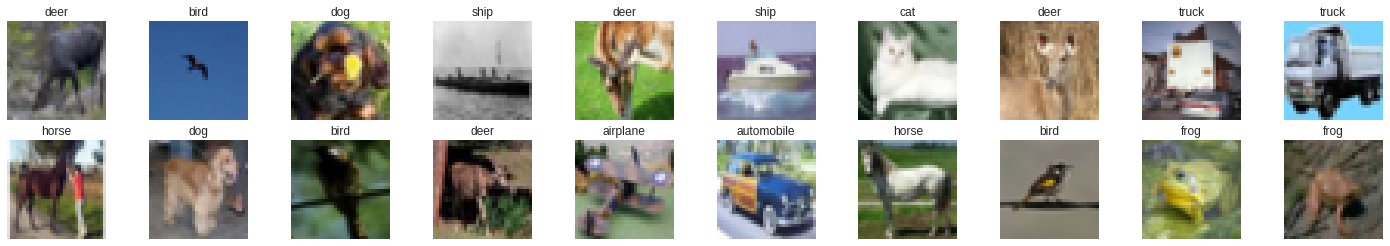

In [7]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]]) 

## Define the Network Architecture

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    
    # Convolutional Layer
    self.conv1 = nn.Conv2d(3,16,3, padding=1)
    self.conv2 = nn.Conv2d(16,32,3,padding=1)
    self.conv3 = nn.Conv2d(32,64,3,padding=1)
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(,120)
    self.fc2 = nn.Linear(120, 60)
    self.fc3 = nn.Linear(60,10)
    
  def forward(self, x):
    
    x =  F.relu(self.conv1(x))
    x =  F.relu(self.conv2(x))
    x =  x.view(-1,32*5*5)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
  
  
model = Net()
print(model)

# move tensors to GPU if CUDA is available
if train_on_gpu:
  model.cuda()




Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (fc3): Linear(in_features=60, out_features=10, bias=True)
)


## Specify Loss Function and Optimizer

In [0]:
import torch.optim as optim
# Specify loss function
criterion = nn.CrossEntropyLoss()
# Specify optmizer
optimizer = optim.SGD(model.parameters(),lr=0.01, momentum =0.9)

## Train the Network

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [17]:
#number of epochs to train the model
n_epochs = 50

valid_loss_min = np.Inf #to track the changes in the validation loss

for epoch in range(1,n_epochs+1):
  
  #keep track of training and validation loss
  train_loss = 0 
  valid_loss = 0
  
  ################
  #Training model#
  ################
  
  model.train()
  for data,target in train_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    
    #Clear the gradients of all optimized variables
    optimizer.zero_grad()
    #Forward pass
    output = model(data)
    #calculate loss
    loss = criterion(output,target)
    #backward pass
    loss.backward()
    #perform optimizer step
    optimizer.step()
    #update training loss
    train_loss +=loss.item()*data.size(0)
    
  #####################
  #Validate the model #
  #####################
  
  model.eval()
  for data,target in valid_loader:
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # perform forward pass on validation data
    
    output = model(data)
    # calculate the loss
    loss = criterion(output,target)
    # update average validation loss
    valid_loss += loss.item()*data.size(0)
    
  
  # calculate average loss
  train_loss = train_loss/len(train_loader.dataset)
  valid_loss = valid_loss_loss/len(valid_loader.dataset)
  
  # print training / validation metrics
  print('Epoch:{}\t Training Loss:{:6F} \t Validation Loss:{6f}'.format(epoch,train_loss,valid_loss))
  
  #save model if validation loss is decreased
  
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
    torch.save(model.state_dict(),'model_cifar.pt')
    valid_loss_min = valid_loss
    
    
  

RuntimeError: ignored